In [1]:
%load_ext autoreload
%autoreload 2

# SpookyNet


In [2]:
import sys
from pathlib import Path

# change to your NFF path
sys.path.insert(0, "C:/Users/fraja/Documents/entrenador_simulador/NeuralForceField")

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data.sampler import RandomSampler


from nff.data import Dataset, split_train_validation_test, collate_dicts, to_tensor
from  nff.train import Trainer, get_trainer, get_model, load_model, loss, hooks, metrics, evaluate

In [3]:
DEVICE = "cuda:0"
OUTDIR = './spooky'
# batch size in the original paper
BATCH_SIZE = 128
# cutoff in original paper 
bohr_radius = 0.529
r_cut = 10 * bohr_radius


path = 'NeuralForceField/data/Si16Vplus.pth.tar' 

path = 'NeuralForceField/data/Si16Vplus_dipole.pth.tar' 
dataset = Dataset.from_file(path)



In [4]:
dataset

In addition to the usual neighbor list, we must also generate a neighbor list that has infinite cutoff (i.e. couples all pairs of atoms in each molecule) so that we can add the electrostatics terms. This neighbor list should be called `mol_nbrs`:

In [5]:
_ = dataset.generate_neighbor_list(cutoff=r_cut,
                                   key='nbr_list',
                                   undirected=False,
                                   offset_key='offsets')

_ = dataset.generate_neighbor_list(cutoff=float('inf'),
                                   key='mol_nbrs',
                                   undirected=True,
                                   offset_key='mol_offsets')

Note also that this dataset has `charge` and `spin` as properties, which are necessary for SpookyNet:

Now we split the dataset:

In [6]:
#10000
train, val, test = split_train_validation_test(dataset, 
                                               val_size=0.1, 
                                               test_size=0.01,
                                               seed=0)

Next we make the model. If you set `non_local=True`, make sure to install [PyTorch Performer](https://github.com/lucidrains/performer-pytorch), which computes attention in order N time for N atoms. This can be done with `pip install performer-pytorch`.



In [7]:
modelparams = dict(
        output_key='energy',
        dip_key='dipole',
        #charge_key='q',
        activation="swish",
        num_features=128, # Dimensions of feature space
        num_basis_functions=16, # Number of radial basis functions.
        num_modules=6, # Number of modules (iterations) for constructing atomic features.
        num_residual_electron=1, # Number of residual blocks applied to features encoding the electronic 
                                 # state
        num_residual_pre=1, # Number of residual blocks applied to atomic features in each module
                            # (before other transformations)
        num_residual_local_x=1, # Number of residual blocks (per module) applied to atomic features in 
                                # local interaction
        num_residual_local_s=1, # Number of residual blocks (per module) applied to s-type interaction 
                                # featur esin local interaction
        num_residual_local_p=1, # Number of residual blocks (per module) applied to p-type interaction 
                                # features in local interaction
        num_residual_local_d=1, # Number of residual blocks (per module) applied to d-type interaction 
                                # features in local interaction
        num_residual_local=1,
        num_residual_nonlocal_q=1,
        num_residual_nonlocal_k=1,
        num_residual_nonlocal_v=1,
        num_residual_post=1, # Number of residual blocks applied to atomic features after
                             # interaction with neighbouring atoms (per module)
        num_residual_output=1, # Number of residual blocks applied to atomic features in output
                               # branch (per module)
        basis_functions="exp-bernstein", #  Kind of radial basis functions. Possible values:
                                         # 'exp-bernstein': Exponential Bernstein polynomials.
                                         # 'exp-gaussian': Exponential Gaussian functions.
                                         # 'bernstein': Bernstein polynomials.
                                         # 'gaussian': Gaussian functions.
        exp_weighting=True, # Apply exponentially decaying weights to radial basis functions. Only
                            # used when 'basis_functions' argument is 'exp-bernstein' or
                            # 'exp-gaussian'. Probably has almost no effect unless the weights of
                            # radial functions are regularized.
        cutoff=r_cut, # Cutoff radius for (neural network) interactions.
        lr_cutoff=None, # Cutoff radius for long-range interactions (no cutoff is applied when
                        # this argument is None)
        use_zbl_repulsion=True, # If True, short-range repulsion inspired by the ZBL repulsive
                                # potential is applied to the energy prediction.
        use_electrostatics=True, # If True, point-charge electrostatics for the predicted atomic
                                 # partial charges is applied to the energy prediction
        use_d4_dispersion=True, # If True, Grimme's D4 dispersion correction is applied to the energy
                                # prediction
        use_irreps=True, # For compatibility with older versions of the code
        use_nonlinear_embedding=False, # For compatibility with older versions of the code
        compute_d4_atomic=False, # If True, atomic polarizabilities and C6 coefficients in Grimme's D4
                                 # dispersion correction are computed
        module_keep_prob=1.0, # Probability of keeping the last module during training. Module
                              # dropout can be a useful regularization that encourages
                              # hierarchicacally decaying contributions to the atomic features.
                              # Earlier modules are dropped with an automatically determined lower
                              # probability. Should be between 0.0 and 1.0
        load_from=None, # Load saved parameters from the given path instead of using random
                        # initialization (when 'load_from' is None)
        Zmax=87, # Maximum nuclear charge +1 of atoms. The default is 87, so all
                 # elements up to Rn (Z=86) are supported. Can be kept at the default
                 # value (has minimal memory impact). Note that Grimme's D4 dispersion
                 # can only handle elements up to Rn (Z=86)
        zero_init=True # Initialize parameters with zero whenever possible?
)


model = get_model(modelparams, model_type="RealSpookyNet")

# untrained model to test for equivariant/invariant outputs
original_model = copy.deepcopy(model)

Note that you should probably only use the D4 dispersion term if your ground truth quantum chemistry method contains dispersion

In [8]:
if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)
        
    shutil.move(OUTDIR, newpath)

Next we make the training splits, loaders, and trainer. A few notes:
- In addition the normal force and energy loss terms, you can add a loss term for the dipole moment, so that the model can learn partial charges to reproduce the dipole. In addition or in place of this loss, you can add a loss term for partial charges. This dataset contains partial charges and not dipoles, so we use the latter.
- Remember to use a random sampler for the train loader, because that makes a big difference in the results (at least for small datasets)


In [9]:
from nff.utils.constants import BOHR_RADIUS, KCAL_TO_AU

grad_conv = KCAL_TO_AU['energy'] * KCAL_TO_AU['_grad']
en_conv = KCAL_TO_AU['energy']


train_loader = DataLoader(train, 
                          batch_size=BATCH_SIZE, 
                          collate_fn=collate_dicts,
                          sampler=RandomSampler(train))

val_loader = DataLoader(val, 
                        batch_size=BATCH_SIZE, 
                        collate_fn=collate_dicts)

test_loader = DataLoader(test, 
                         batch_size=BATCH_SIZE, 
                         collate_fn=collate_dicts)

# loss coefficients in the original paper (the paper used AU so
# we convert their 1/1/1 loss from atomic units). They also
# use an RMSE loss

loss_fn = loss.build_rmse_loss(loss_coef={'energy_grad': 1.0 * grad_conv, 
                                          'energy': 1.0 * en_conv,
                                          #add 11/11/23
                                          'dipole': 1.0
                                          #'q': 1.0
                                          })

trainable_params = filter(lambda p: p.requires_grad, model.parameters())
# Loss rate in original paper was 1e-3 and they used amsgrad
optimizer = Adam(trainable_params, 
                 lr=1e-3,
                 amsgrad=True)


train_metrics = [
    metrics.MeanAbsoluteError('energy'),
    metrics.MeanAbsoluteError('energy_grad'),
    #add 11/11/23
    metrics.MeanAbsoluteError('dipole')

]


train_hooks = [
    hooks.MaxEpochHook(5000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | ',
        time_strf='%M:%S'
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=25,
        factor=0.5,
        min_lr=1e-5,
        window_length=1,
        stop_after_min=True
    )
]

T = Trainer(
    model_path=OUTDIR,
    modelparam = modelparams,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
    checkpoint_interval=1,
    hooks=train_hooks,
    mini_batches=1
)

In [10]:
torch.cuda.get_device_name(1)

'NVIDIA GeForce GTX 1060 3GB'

In [11]:
T.train(device=DEVICE, n_epochs=16)


 Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy | MAE_energy_grad | MAE_dipole | GPU Memory (MB)


 97%|█████████▋| 35/36 [00:27<00:00,  1.27it/s]


09:08 |     1 |     1.000e-03 |     0.0767 |          0.0686 |     7.4866 |          7.2807 |     0.0505 |            5609


 97%|█████████▋| 35/36 [00:24<00:00,  1.41it/s]


09:35 |     2 |     1.000e-03 |     0.0683 |          0.0685 |     7.5317 |          7.2784 |     0.0504 |            5609


 97%|█████████▋| 35/36 [00:26<00:00,  1.34it/s]


10:03 |     3 |     1.000e-03 |     0.0684 |          0.0692 |     8.0549 |          7.2753 |     0.0503 |            5609


 44%|████▍     | 16/36 [00:11<00:14,  1.40it/s]

In [ ]:
import json 
def load_params(param_path):
    with open(param_path, "r") as f:
        info = json.load(f)
    keys = ['details', 'modelparams']
    params = None
    for key in keys:
        if key in info:
            params = info[key]
            break
    if params is None:
        params = info

    model_type = params['model_type']

    return params, model_type


def load_model(path, params=None, model_type=None, **kwargs):
    """Load pretrained model from the path. If no epoch is specified,
            load the best model.

    Args:
            path (str): path where the model was trained.
            params (dict, optional): Any parameters you need to instantiate
                    a model before loading its state dict. This is required for DimeNet,
                    in which you can't pickle the model directly.
            model_type (str, optional): name of the model to be used
    Returns:
            model
    """

    try:
        if os.path.isdir(path):
            print('pase')
            return torch.load(os.path.join(path, "best_model"), map_location="cpu")
        elif os.path.exists(path):
            return torch.load(path, map_location="cpu")
        else:
            raise FileNotFoundError("{} was not found".format(path))
    except (FileNotFoundError, EOFError, RuntimeError):

        param_path = os.path.join(path, "params.json")
        if os.path.isfile(param_path):
            params, model_type = load_params(param_path)

        assert params is not None, "Must specify params if you want to load the state dict"
        assert model_type is not None, "Must specify the model type if you want to load the state dict"

        model = get_model(params, model_type=model_type, **kwargs)

        if os.path.isdir(path):
            state_dict = torch.load(os.path.join(
                path, "best_model.pth"), map_location="cpu")
        elif os.path.exists(path):
            state_dict = torch.load(path, map_location="cpu")
        else:
            raise FileNotFoundError("{} was not found".format(path))

        model.load_state_dict(state_dict["model"], strict=False)
        return model


In [13]:
from sklearn.metrics import r2_score


best_model = load_model(OUTDIR, modelparams, 'RealSpookyNet')

pase


In [14]:
OUTDIR

'./spooky'

In [15]:
#best_model.save('prueba.pth')

In [16]:

#import pickle
# Save the DataLoader
#filename = 'dataloader.pkl'
#with open(filename, 'wb') as f:
#    pickle.dump(val_loader, f)

In [17]:
results, targets, val_loss = evaluate(best_model,
                                      val_loader, 
                                      loss_fn, 
                                      device=DEVICE)

100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


In [18]:
pred_fn = torch.cat
targ_fn = torch.stack

In [19]:
pred_fn = torch.cat
pred = pred_fn(results['dipole'], dim=0).view(-1).detach().cpu().numpy()

In [20]:
targ = targ_fn(targets['dipole'], dim=0).view(-1).detach().cpu().numpy()

In [21]:
pred

array([ 1.4349331 , -0.3052582 ,  1.7892259 , ...,  1.4306899 ,
       -0.38426262,  1.8100042 ], dtype=float32)

In [22]:
targets['dipole']
targ

array([ 1.4199275 , -0.33831722,  1.8204195 , ...,  1.5311793 ,
       -0.4717738 ,  1.8998802 ], dtype=float32)

energy 505
energy_grad 25755
dipole 1515


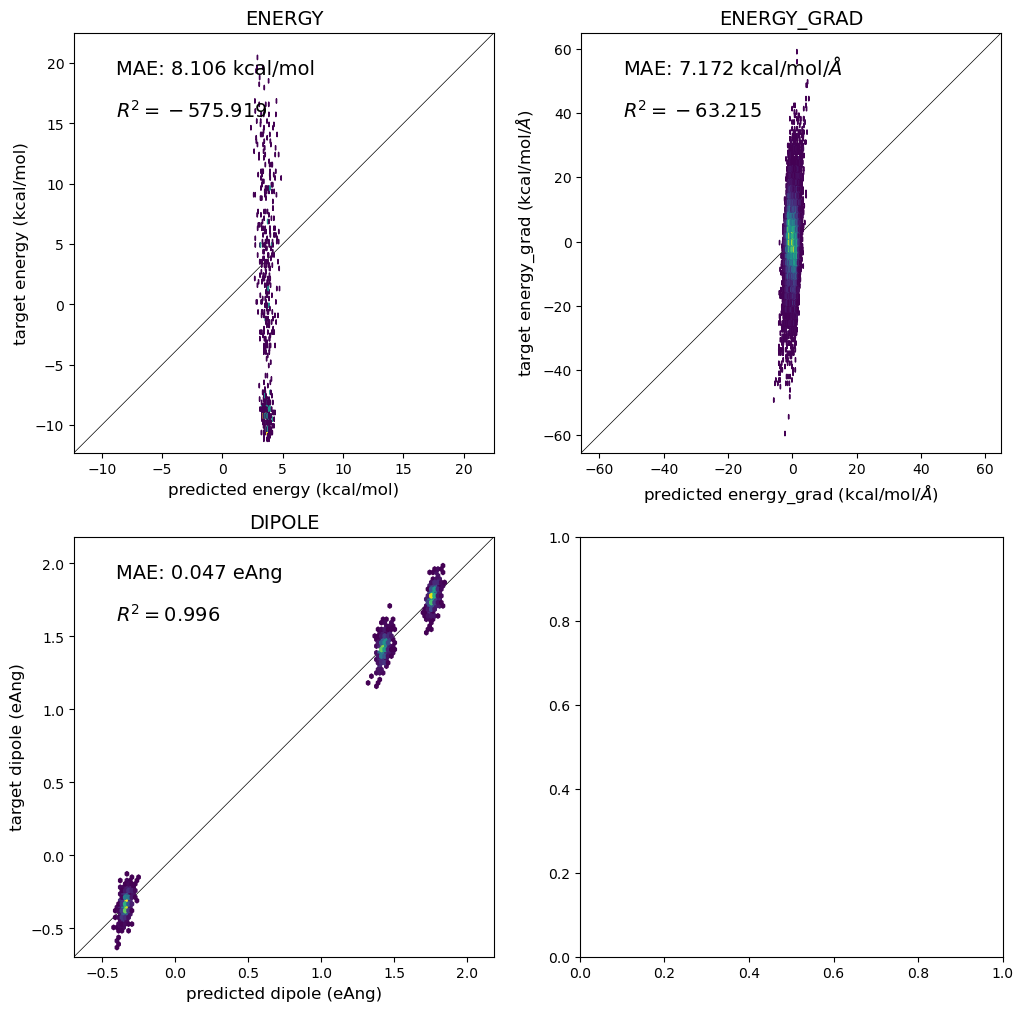

In [23]:

units = {
    'energy': 'kcal/mol',
    'energy_grad': r'kcal/mol/$\AA$',
    'dipole': 'eAng'
    #'q': '$e$'
}

fig, ax_figs = plt.subplots(2, 2, figsize=(12, 12))
all_units = list(units.keys())
energi= []
for i, ax_fig in enumerate(ax_figs):
    
    keys = all_units[i * 2: i * 2 + 2]
    
    for ax, key in zip(ax_fig, keys):
        
        pred_fn = torch.cat
        targ_fn = torch.cat
        if all([len(i.shape) == 0 for i in results[key]]):
            pred_fn = torch.stack
        if all([len(i.shape) == 0 for i in targets[key]]):
            targ_fn = torch.stack

        pred = pred_fn(results[key], dim=0).view(-1).detach().cpu().numpy()
        targ = targ_fn(targets[key], dim=0).view(-1).detach().cpu().numpy()
        print(key,len(pred))
        if key == 'energy' :
            energi.append(pred)
        mae = abs(pred-targ).mean()

        ax.hexbin(pred, targ, mincnt=1)

        lim_min = min(np.min(pred), np.min(targ)) * 1.1
        lim_max = max(np.max(pred), np.max(targ)) * 1.1

        ax.set_xlim(lim_min, lim_max)
        ax.set_ylim(lim_min, lim_max)
        ax.set_aspect('equal')

        ax.plot((lim_min, lim_max),
                (lim_min, lim_max),
                color='#000000',
                zorder=-1,
                linewidth=0.5)
    
        r2 = r2_score(pred, targ)
        
        ax.set_title(key.upper(), fontsize=14)
        ax.set_xlabel('predicted %s (%s)' % (key, units[key]), fontsize=12)
        ax.set_ylabel('target %s (%s)' % (key, units[key]), fontsize=12)
        ax.text(0.1, 0.9, 'MAE: %.3f %s' % (mae, units[key]), 
               transform=ax.transAxes, fontsize=14)
        ax.text(0.1, 0.8, '$R^2=%.3f$' % r2, 
               transform=ax.transAxes, fontsize=14)
    
plt.show()

In [ ]:
pred

array([ 0.1031299 , -0.00098995, -0.07543278, ..., -0.5292323 ,
        0.87569743,  0.47132024], dtype=float32)

In [ ]:
targ

array([13.405078  , -4.4439187 , -6.181459  , ...,  6.5319796 ,
        6.4022026 ,  0.01886543], dtype=float32)